<a href="https://colab.research.google.com/github/PiotMik/OIS_curve_modeling/blob/main/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling the OIS Curve - Sterling example

## Introduction

In this notebook we present the PCA-Factor Copula model for the OIS Curve. 
We show how the OIS rate is influenced by SONIA, which in turn is influenced by the BoE policy rate.

We develop a Vasicek model with dynamic mean for simulating the overnight SONIA rate with the ability to influence simulation by expert judgement of BoE movements. We also present a framework of PCA-Factor Copula model for the movements of longer OIS Curve tenors and fit it to the historical data.

The full framework is incorporated into a Monte-Carlo simulation of the full OIS Curve.

In [468]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
from typing import Callable, Optional
from datetime import date
plt.style.use('seaborn-deep')
sns.set_context('talk')
sns.set_palette(sns.color_palette('Set3'))
plt.rcParams['figure.figsize'] = (10, 8)

In [463]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

## Data

[OIS](https://www.bankofengland.co.uk/statistics/yield-curves) and [SONIA](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N) data is freely available at the Bank of England official pages. 

We collect 6 years of daily observations for SONIA and 60 tenors of the OIS curve.


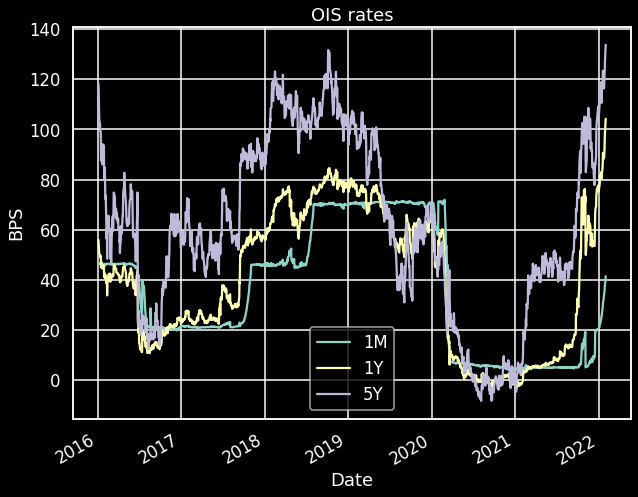

In [469]:
ois_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/OIS%20spot.csv'
sonia_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/SONIA.csv'

def tenor_parser(month_number: int):
  """
  Refactor integer month number into string like: 23 -> '1Y3Q2M' 

  Parameters
  ----------
  month_number: int
    Integer representing the number of months
  
  Returns
  -------
  str
    Formatted string
  """
  years = np.floor(month_number/12)
  months = (month_number - 12*years)

  y_str = f"{int(years)}Y" * int(years > 0)
  m_str = f"{int(months)}M" * int(months > 0)
  
  return y_str + m_str

# OIS load
ois = pd.read_csv(ois_url,
                  index_col= ['Maturity'], parse_dates=True, dayfirst=True)
ois = ois.sort_index()*100.0
ois.columns = [tenor_parser(int(month)) for month in ois.columns]
ois.index.name = 'Date'

# SONIA load
sonia = pd.read_csv(sonia_url,
                    index_col=['Date'], parse_dates=True, dayfirst=True)
sonia = sonia.sort_index()* 100.0

# Concatenate
rates = pd.concat([sonia, ois], axis = 1).dropna()

rates.iloc[:, [1, 12, 60]].plot()
plt.title('OIS rates')
plt.ylabel('BPS')
plt.xlabel('Date');

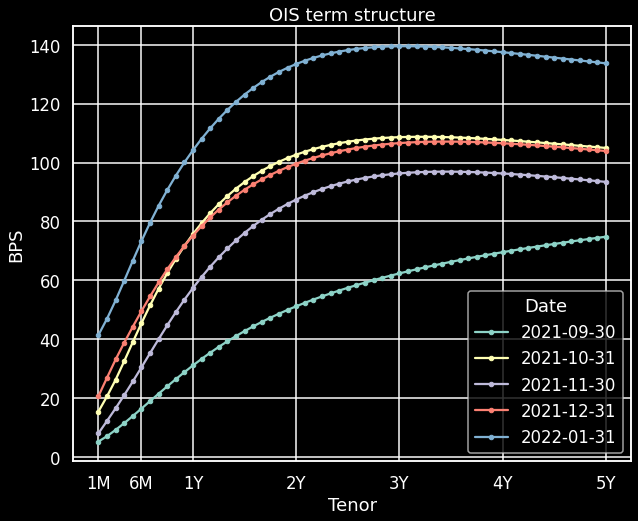

In [466]:
term_structure_df = rates.drop(['SONIA'], axis=1).tail(100).resample('M').last().T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')
tenors = np.array([1, 6, 12, 24, 36, 48, 60]) - 1
plt.xticks(tenors, ois.columns[tenors]);

## SONIA model

The Sterling Overnight Index Average (SONIA) is the preferred alternative reference rate for the British debt market, proposed in place of GBP LIBOR after it's cessation.

Unlike LIBOR, which was a panel average, SONIA is calculated based on actual market transactions which shields this index from being susceptible to market manipulation.

SONIA is calculated as the trimmed mean, rounded to four decimal places, of interest rates paid on eligible sterling-denominated deposit transactions. This trimmed mean is calculated as the volume-weighted mean rate, based on the central 50% of the volume-weighted distribution of rates. Eligible transactions are those which are:

- Reported to the Bank of England’s Sterling Money Market daily data collection
- Unsecured and of one business day maturity
- Executed between 00:00 and 18:00 UK time, and settled that same day
- Greater than or equal to £25 million in value

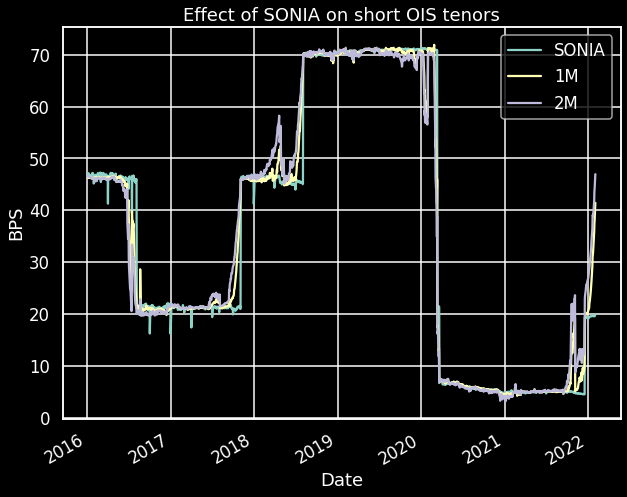

In [467]:
rates.iloc[:, :3].plot()
plt.title('Effect of SONIA on short OIS tenors')
plt.ylabel('BPS')
plt.xlabel('Date');

### Hull-White model

To model SONIA we employ a simplified Hull-White model, which is a Vasicek model, but with non-constant long term mean $\mu_t$.

$$ dr_t = b(\mu_t - r_t)dt + \sigma dW_t$$ 

Using such model will allow us to incorporate expert predictions for the level of SONIA into the model

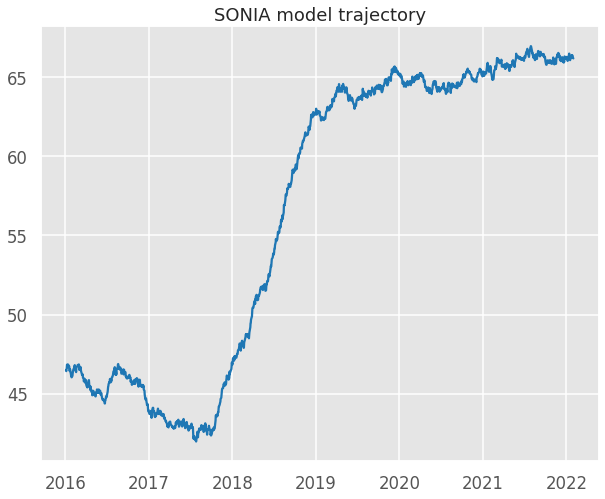

In [278]:
class HullWhiteModel():
    
  def __init__(self, b, mu_t, sigma):
    self.b = b
    self.mu_t = mu_t
    self.sigma = sigma

  def simulate(self,
               x0, dates):
    
    random_toss = np.random.rand(len(dates) - 1).round()*2 - 1
    dt = 1/255.

    for i, date in enumerate(dates):
      if i == 0:
        xt = [x0]
        t = [date]
      x_k = xt[-1] + self.b*(self.mu_t(t[-1]) - xt[-1])*dt + self.sigma*np.random.randn()*np.sqrt(dt)
      xt.append(x_k)
      t.append(date)
    return np.array(t), np.array(xt)

dates = np.array(ois.index)

def mu_t(date):
  if date < np.datetime64('2016-09-01'):
    return sonia.iloc[0]
  elif date < np.datetime64('2017-10-01'):
    return sonia.iloc[0] - 5.
  elif date < np.datetime64('2018-06-01'):
    return sonia.iloc[0] + 10.
  else:
    return sonia.iloc[0] + 20.

model = HullWhiteModel(b = 2.0, # 70.0
                       mu_t = mu_t,
                       sigma = 2.0) # 2.0

t, xt = model.simulate(dates = dates,
                       x0 = sonia.iloc[0])

plt.plot(t, xt)
plt.title('SONIA model trajectory');

## How do Bank of England policies influence OIS rates?

The Bank of England announces it's key rate, known as BoE rate.
This BoE rate is a reference rate, heavily influencing short term lending. As a result, SONIA closely follows BoE rate, and OIS rates follow SONIA.

See:
- [BoE rate](https://www.bankofengland.co.uk/monetary-policy/the-interest-rate-bank-rate)
- [SONIA rate](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N)

### BoE rate based SONIA model

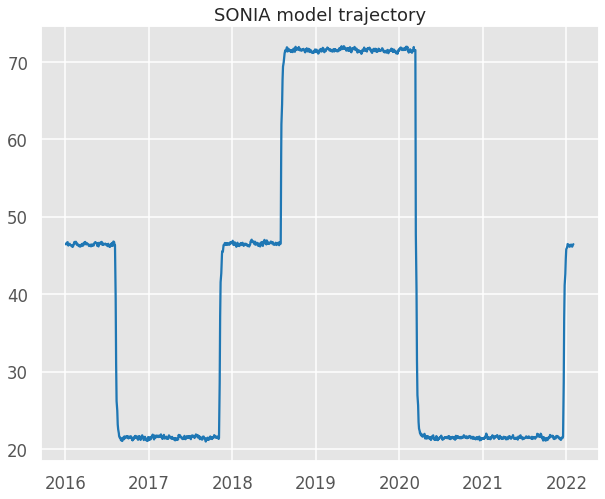

In [279]:
def boe_rate_pred(date):
  if date < np.datetime64('2016-08-05'):
    return sonia.iloc[0]
  elif date < np.datetime64('2017-11-03'):
    return sonia.iloc[0] - 25.
  elif date < np.datetime64('2018-07-31'):
    return sonia.iloc[0] + 0.
  elif date < np.datetime64('2020-03-11'):
    return sonia.iloc[0] + 25.
  elif date < np.datetime64('2020-03-20'):
    return sonia.iloc[0] - 25.
  elif date < np.datetime64('2020-03-20'):
    return sonia.iloc[0] - 40.
  elif date < np.datetime64('2021-12-17'):
    return sonia.iloc[0] - 25.
  else:
    return sonia.iloc[0] + 0.

model = HullWhiteModel(b = 70.0,
                       mu_t = boe_rate_pred,
                       sigma = 2.0)

t, xt = model.simulate(dates = dates,
                       x0 = sonia.iloc[0])

plt.plot(t, xt)
plt.title('SONIA model trajectory');

## OIS Curve dynamics model



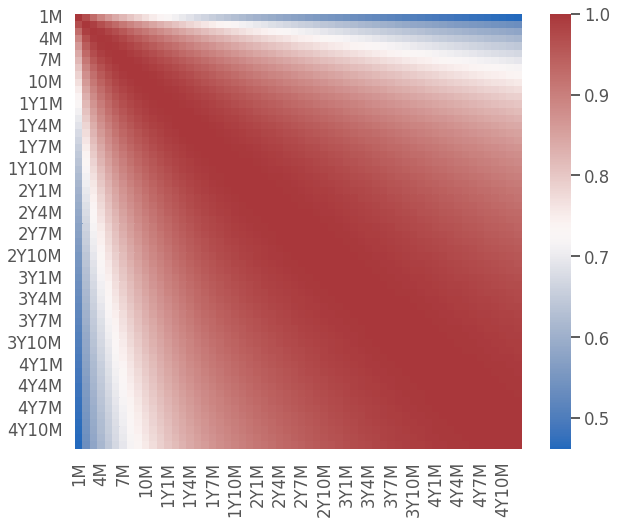

In [280]:
diffs = (rates[ois.columns].sub(rates['SONIA'], axis=0)).diff().dropna()

sns.heatmap(diffs.corr(), cmap='vlag')

### PCA - idea

In highly correlated systems, we can use eigenvectors of the covariance matrix, to arrive at a new, orthogonal system.
This system will typically consist of fewer significant dimensions than the original one. This enables a projection of the data to a lower dimensional feature space without significant loss of information.

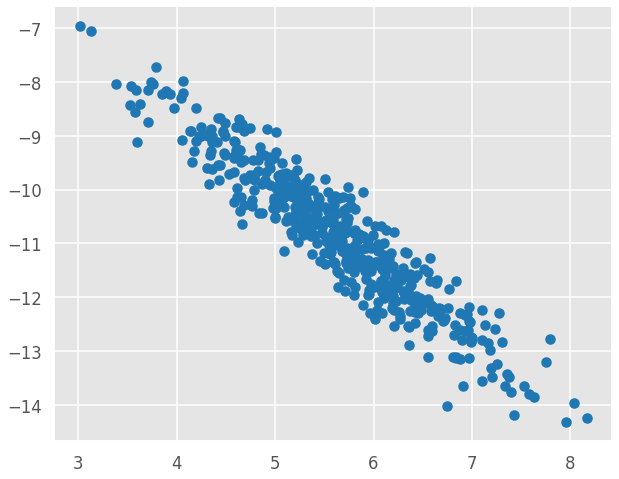

In [430]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=[500],  random_state=42)
transformation = [[-0.8, 0.9], [0.4, -0.95]]
X = np.dot(X, transformation)
plt.scatter(X[:, 0], X[:, 1]);

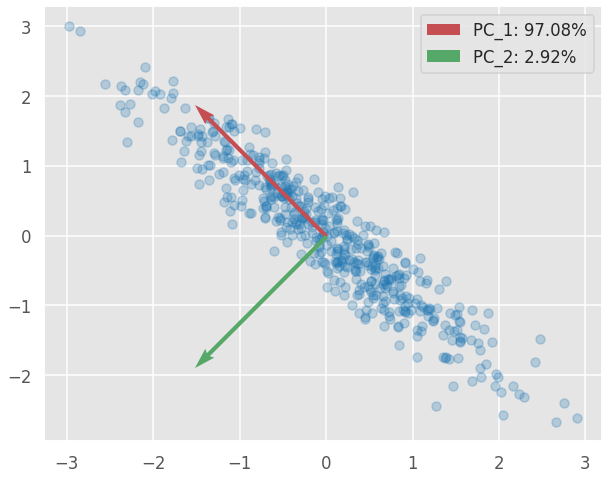

In [434]:

pca = PCA(2)

X = (X - X.mean(axis=0))/X.std(axis=0)
origin =  X.mean(axis=0)
pca.fit(X)
V = pca.components_

plt.scatter(X[:, 0], X[:, 1], alpha = 0.25)
plt.quiver(*origin, *V[0],
           scale = 3,
           color=['r'], label=f'PC_1: {pca.explained_variance_ratio_[0]:.2%}')
plt.quiver(*origin, *V[1],
           scale = 3,
           facecolor='g', label=f'PC_2: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend()
plt.show()

## PCA - application to OIS curve

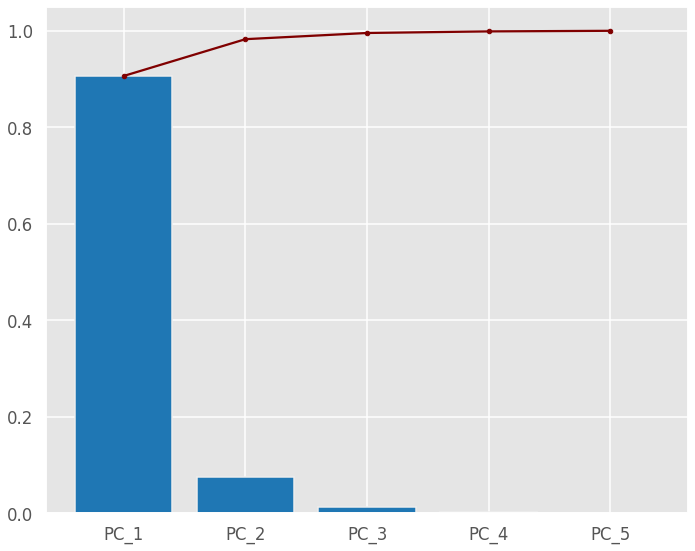

In [438]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
diffs = (rates[ois.columns].sub(rates['SONIA'], axis=0)).diff().dropna()
sc.fit(diffs)

diffs = sc.transform(diffs)
pca = PCA()
pca.fit(diffs)

exp_var = pd.DataFrame(pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
exp_var['Cumulative explained variance'] = pca.explained_variance_ratio_.cumsum()

max_n = 5
plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
plt.tight_layout()

In [439]:
exp_var.head(10)

,Explained variance,Cumulative explained variance
PC_1,0.905902,0.905902
PC_2,0.076155,0.982057
PC_3,0.012818,0.994875
PC_4,0.003290,0.998164
PC_5,0.001214,0.999378
PC_6,0.000392,0.999770
PC_7,0.000158,0.999928
PC_8,0.000050,0.999979
PC_9,0.000016,0.999995
PC_10,0.000004,0.999999


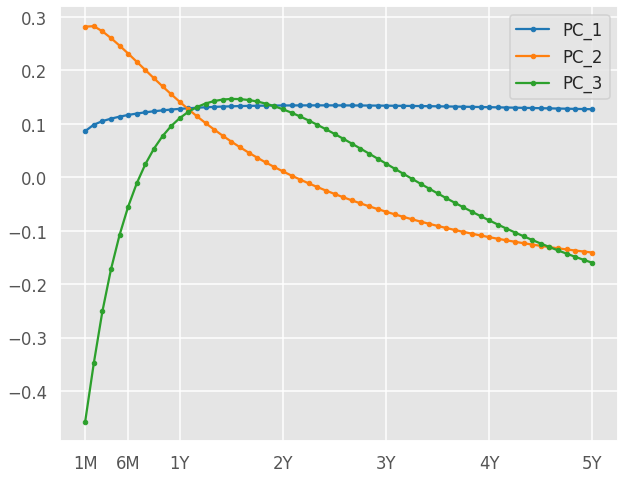

In [441]:
pca = PCA(3)
pca.fit(diffs)

components = pd.DataFrame(pca.components_, 
                          columns = ois.columns,
                          index=[f'PC_{i + 1}' for i in range(pca.n_components)]).T
components.plot(marker='.')
pd.DataFrame(pca.explained_variance_ratio_.cumsum(),
             columns = ['Cumulative explained variance'],
             index = [f'PC_{i+1}' for i in range(pca.n_components)])
tenors = np.array([1, 6, 12, 24, 36, 48, 60]) - 1
plt.xticks(tenors, ois.columns[tenors]);